In [1]:
# Let's load all of our data
from torch import nn
import torch
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

#  And let's load the ml_tools.py
%run cardiac_ml_tools.py

In [3]:
# We are reading the filesystem and getting the file directories 
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='../Datasets/intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)

In [11]:
# Now, let's load the data itself\
ecg = []
for file_ecg, file_volt in file_pairs:
    ecg.append(get_standard_leads(np.load(file_ecg)))
ecg = np.stack(ecg, axis = 0)
print(ecg.shape)

(16117, 500, 12)


In [12]:
# Let's figure out the training data and testing data
ecg_training_data = ecg[:int(0.8*ecg.shape[0])]
ecg_testing_data = ecg[int(0.8*ecg.shape[0]):]

In [13]:
# How is the model for the RNN going to be

# We need to define the input shape
# Then we need to define the output shape
# Then we need to define the model!
from torch import nn
import torch
from torch import optim

class RNN(nn.Module):
    def __init__(self, inpDim, outDim):
        super().__init__()
        self.EcgStack = nn.Sequential(
            nn.Linear(inpDim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, inpDim),
            nn.ReLU(),
            nn.Softmax()
        )
        
    def forward(self, EcgInp):
        # Let's have input aggregated for both the Voltage
        
        # If train vs if not-train
        EcgOutput = []
        if self.train:
            for i in range(500):
                if i != 499:
                    EcgOutput.append(self.EcgStack(EcgInp[i,:]))

                
        if not self.train:
            EcgInp = EcgInp[0,:]

            # Just take the first step
            EcgOutput.append(EcgInp)
            for i in range(500):
                EcgOp = self.EcgStack(EcgInp)
                EcgOutput.append(EcgOp)     
        
        return torch.stack(EcgOutput, axis=0)
    
    

In [25]:
# Let's see if the network works
model = RNN(inpDim = 12, outDim=75)
model.train()
ecg = model(torch.from_numpy(ecg_training_data[0, :,:]).float())
print(ecg.shape)

# Alright, if it works, create the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

torch.Size([499, 12])


/Users/aditya-the-great/miniconda3/envs/torch-dev/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
# Now let's start training the stuff
EPOCHS = 10

# Iterate over the data
training_data_points = ecg_training_data.shape[0]
for epoch in range(EPOCHS):
    for i in range(training_data_points):
        torchEcg = torch.from_numpy(ecg_training_data[i, :,:])
        torchNEcg = model(torchEcg.float())
        loss = torch.mean(torch.square(torchNEcg - torchEcg[1:,:]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:    
            print('Epoch:'+str(epoch)+' Loss: '+str(loss.item()) +' iterate: ' +str(i))
        
        if (i+1) % 13000 == 0:
            break

    
    
    

Epoch:0 Loss: 0.05549771136002855 iterate: 9
Epoch:0 Loss: 0.1477966277318946 iterate: 19
Epoch:0 Loss: 0.10279217049379442 iterate: 29
Epoch:0 Loss: 0.0493450168410959 iterate: 39
Epoch:0 Loss: 0.0903923823217024 iterate: 49
Epoch:0 Loss: 0.06251231549833836 iterate: 59
Epoch:0 Loss: 0.11184687595521209 iterate: 69
Epoch:0 Loss: 0.04740544543832022 iterate: 79
Epoch:0 Loss: 0.07496152483351495 iterate: 89
Epoch:0 Loss: 0.03352628120517923 iterate: 99
Epoch:0 Loss: 0.033024667084183584 iterate: 109
Epoch:0 Loss: 0.06293620611250575 iterate: 119
Epoch:0 Loss: 0.03129428545656336 iterate: 129
Epoch:0 Loss: 0.09335569865800432 iterate: 139
Epoch:0 Loss: 0.06843430762290278 iterate: 149
Epoch:0 Loss: 0.11061789290337289 iterate: 159
Epoch:0 Loss: 0.07560491985910564 iterate: 169
Epoch:0 Loss: 0.06127453034743152 iterate: 179
Epoch:0 Loss: 0.114273071921563 iterate: 189
Epoch:0 Loss: 0.07903290847901148 iterate: 199
Epoch:0 Loss: 0.12819146471418097 iterate: 209
Epoch:0 Loss: 0.041508699564

In [22]:
# Testing the data
model.train = False
torchNEcg = model(torchEcg.float())
print(torchNEcg.shape)

torch.Size([501, 12])


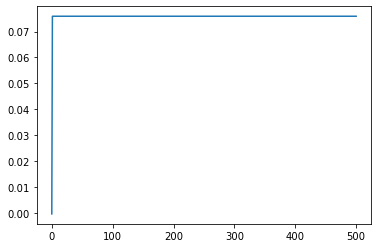

In [24]:

plt.plot(torchNEcg[:,10].detach().numpy())